In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import utils
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Dataset

In [2]:
datapath='./data'
os.makedirs(datapath, exist_ok=True)

# Pre-process
trans = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.5], [0.5])
])

# Load MNIST
train_dataset = datasets.MNIST(datapath, train=True, download=True, transform=trans)

img_shape:  torch.Size([60000, 28, 28])
label_shape:  torch.Size([60000])
img_shape :  torch.Size([60000, 1, 28, 28])


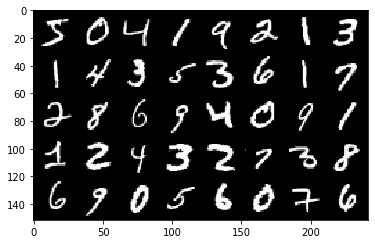

In [3]:
img, label = train_dataset.data, train_dataset.targets
print('img_shape: ', img.shape)
print('label_shape: ', label.shape)

# (Batch)x(Height)x(Width) => (Batch)x(Channel)x(Height)x(Width)
img = img.unsqueeze(1)
print("img_shape : ", img.shape)

# Visualize
img_grid = utils.make_grid(img[:40], ncol=8, padding=2) # 이미지 열어서 확인할 때 사용
def show(img):
  img = img.numpy() # Tensor -> numpy
  img = img.transpose([1,2,0])
  plt.imshow(img, interpolation='nearest')
show(img_grid)

# DataLoader

In [4]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print(len(train_loader))

938


# Define model

In [5]:
params = {
    'num_classes':10,
    'nz':100,
    'input_size':(1,28,28)
}

# Generator

In [6]:
class Generator(nn.Module):
  def __init__(self, params):
    super().__init__()
    self.num_classes = params['num_classes']
    self.nz = params['nz']
    self.input_size = params['input_size']

    self.label_embed = nn.Embedding(self.num_classes, self.num_classes)

    self.gen = nn.Sequential(
        nn.Linear(self.nz + self.num_classes, 128),
        nn.LeakyReLU(0.2),
        nn.Linear(128,256),
        nn.BatchNorm1d(256),
        nn.LeakyReLU(0.2),
        nn.Linear(256,512),
        nn.BatchNorm1d(512),
        nn.LeakyReLU(0.2),
        nn.Linear(512,1024),
        nn.BatchNorm1d(1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024,int(np.prod(self.input_size))),
        nn.Tanh()
    )

  def forward(self, noise, labels):
    gen_input = torch.cat((self.label_embed(labels), noise), -1)
    x = self.gen(gen_input)
    x = x.view(x.size(0), *self.input_size)
    return x

# test
x = torch.randn(16, 100, device=device)
label = torch.randint(0, 10, (16, ), device=device)
model_gen = Generator(params).to(device)
out_gen = model_gen(x, label)
print(out_gen.shape)

torch.Size([16, 1, 28, 28])


# Discriminator

In [7]:
class Discriminator(nn.Module):
  def __init__(self, params):
      super().__init__()
      self.input_size = params['input_size']
      self.nz = params['nz']
      self.num_classes = params['num_classes']

      self.label_embed = nn.Embedding(self.num_classes, self.num_classes)

      self.dis = nn.Sequential(
          nn.Linear(self.num_classes + int(np.prod(self.input_size)), 512),
          nn.LeakyReLU(0.2),
          nn.Linear(512, 512),
          nn.LeakyReLU(0.2),
          nn.Linear(512, 512),
          nn.LeakyReLU(0.2),
          nn.Linear(512,1),
          nn.Sigmoid()
      )

  def forward(self, img, labels):
    dis_input = torch.cat((img.view(img.size(0),-1), self.label_embed(labels)),-1)
    x = self.dis(dis_input)
    return x

# test
x = torch.randn(16,1,28,28, device=device)
label = torch.randint(0,10,(16,), device=device)
model_dis = Discriminator(params).to(device)
output_dis = model_dis(x, label)
print(output_dis.shape)

torch.Size([16, 1])


# Train

In [8]:
loss_func = nn.BCELoss()

from torch import optim

lr = 2e-4
beta1 = 0.5
beta2 = 0.999

opt_dis = optim.Adam(model_dis.parameters(), lr=lr, betas=(beta1, beta2))
opt_gen = optim.Adam(model_gen.parameters(), lr=lr, betas=(beta1, beta2))

nz = params['nz']
num_epochs = 10

loss_history = {
    'gen':[],
    'dis':[]
}

batch_count=0
start_time = time.time()
model_dis.train()
model_gen.train()

for epoch in range(num_epochs):
  for xb, yb in train_loader:
    ba_si = xb.shape[0]

    xb = xb.to(device)
    yb = yb.to(device)
    yb_real = torch.Tensor(ba_si, 1).fill_(1.0).to(device)
    yb_fake = torch.Tensor(ba_si, 1).fill_(0.0).to(device)
    
    model_gen.zero_grad()
    noise = torch.randn(ba_si, 100).to(device)
    gen_label = torch.randint(0,10,(ba_si,)).to(device)

    # Generator
    out_gen = model_gen(noise, gen_label)

    # 이미지 판별
    out_dis = model_dis(out_gen, gen_label)

    loss_gen = loss_func(out_dis, yb_real)
    loss_gen.backward()
    opt_gen.step()

    # Discriminator
    model_dis.zero_grad()
    real_dis = model_dis(xb, yb)
    fake_dis = model_dis(out_gen.detach(), gen_label)

    loss_real = loss_func(real_dis, yb_real)
    loss_fake = loss_func(fake_dis, yb_fake)
    loss_dis = (loss_real + loss_fake) / 2
    loss_dis.backward()
    opt_dis.step()

    loss_history['gen'].append(loss_gen.item())
    loss_history['dis'].append(loss_dis.item())

    batch_count += 1
    if batch_count % 1000 == 0:
      print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' 
            %(epoch, loss_gen.item(), loss_dis.item(), (time.time()-start_time)/60))

Epoch: 1, G_Loss: 0.863270, D_Loss: 0.432158, time: 0.36 min
Epoch: 2, G_Loss: 1.118882, D_Loss: 0.336225, time: 0.63 min
Epoch: 3, G_Loss: 2.133448, D_Loss: 0.299604, time: 0.90 min
Epoch: 4, G_Loss: 1.175657, D_Loss: 0.415491, time: 1.19 min
Epoch: 5, G_Loss: 1.017502, D_Loss: 0.463890, time: 1.46 min
Epoch: 6, G_Loss: 1.112757, D_Loss: 0.445870, time: 1.74 min
Epoch: 7, G_Loss: 1.029255, D_Loss: 0.527531, time: 2.01 min
Epoch: 8, G_Loss: 0.966444, D_Loss: 0.551135, time: 2.28 min
Epoch: 9, G_Loss: 1.128196, D_Loss: 0.481119, time: 2.56 min


# Visualize Loss

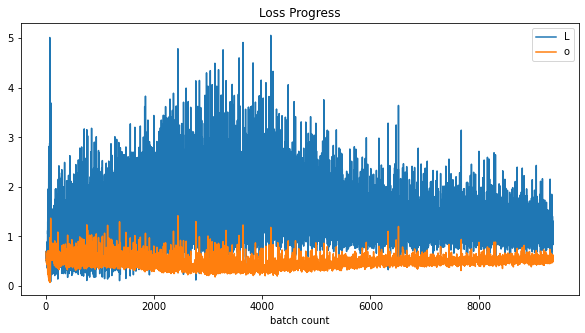

In [11]:
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_history['gen'], label='Gen_loss')
plt.plot(loss_history['dis'], label='Dis_loss')
plt.xlabel('batch count')
plt.legend('Loss')
plt.show()

# Show Fake Image

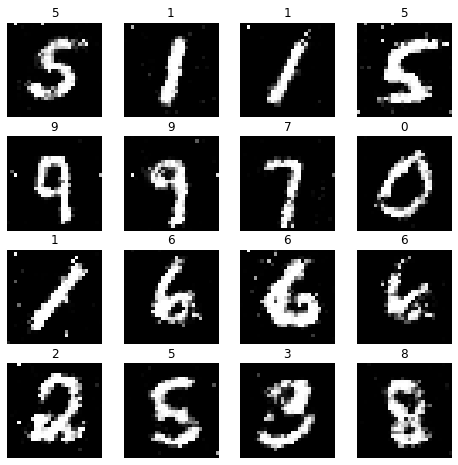

In [12]:
model_gen.eval()

with torch.no_grad():
  fig = plt.figure(figsize=(8,8))
  cols, rows = 4, 4
  for i in range(rows * cols):
    noise = torch.randn(16, 100, device=device)
    label = torch.randint(0, 10, (16, ), device=device)
    img_fake = model_gen(noise, label).detach().cpu()
    fig.add_subplot(rows, cols, i+1)
    plt.title(label[i].item())
    plt.axis('off')
    plt.imshow(img_fake[i].squeeze(), cmap='gray')
plt.show()